In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from emcee.backends import HDFBackend

[INFO] 采样完成，样本数量: 3030


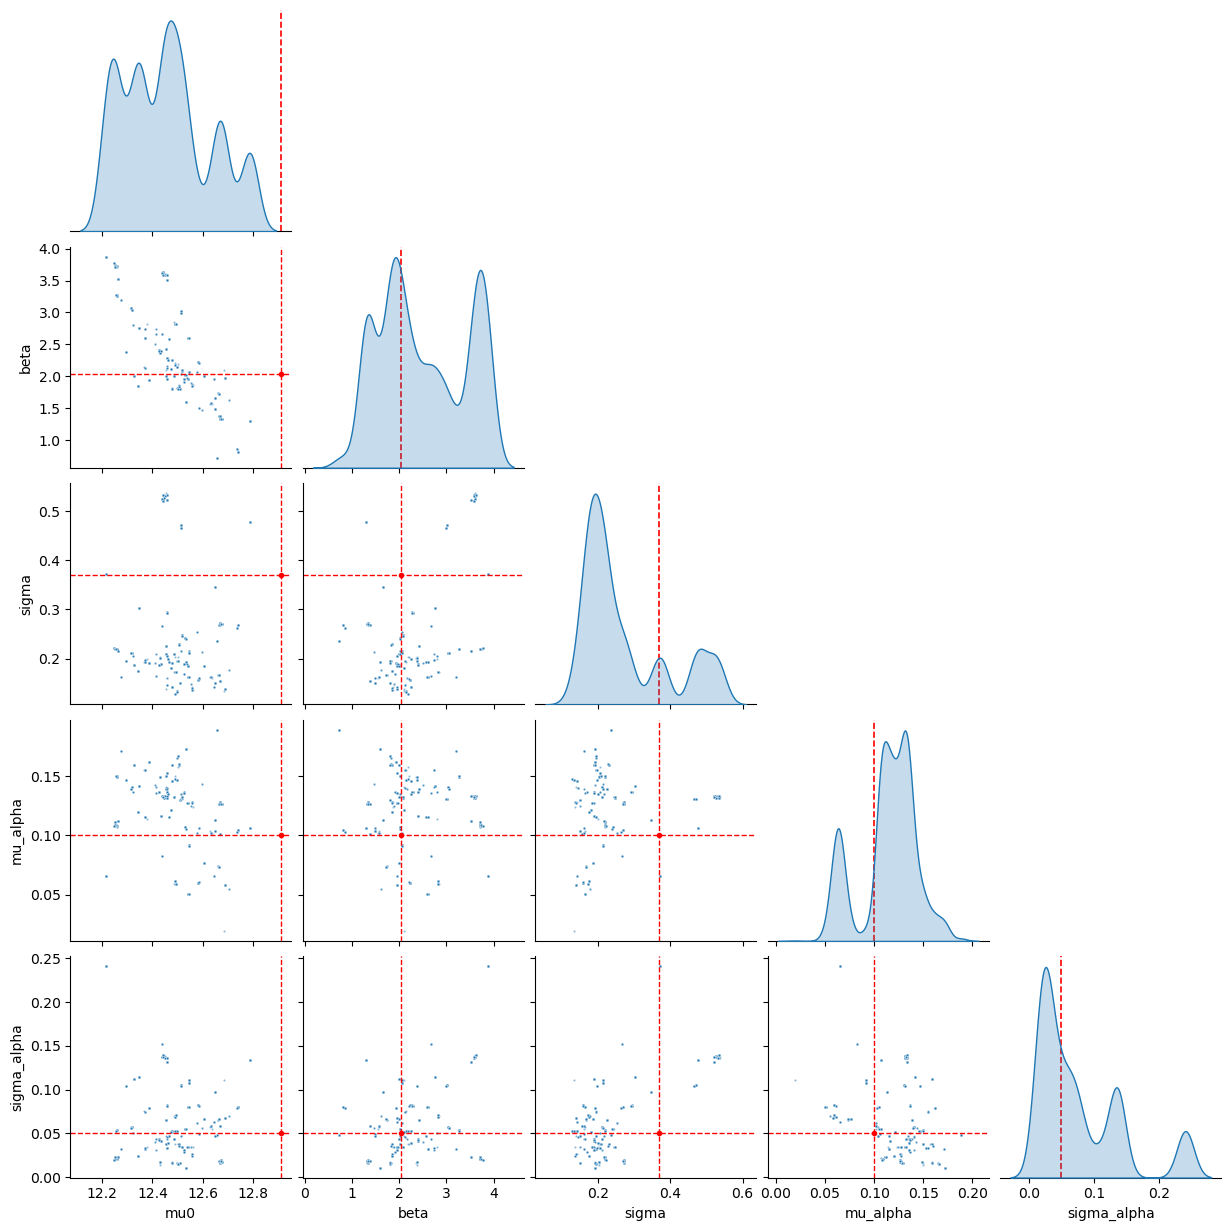

In [7]:

samples = HDFBackend("../chains/chains_eta4.h5").get_chain(flat=True, discard=4000)
df = pd.DataFrame(samples, columns=[
    "mu0", "beta", "sigma", "mu_alpha", "sigma_alpha"
])
print(f"[INFO] 采样完成，样本数量: {len(samples)}")


true_values = {
"mu0": 12.91,
"beta": 2.04,
"sigma": 0.37,
"mu_alpha": 0.1,
"sigma_alpha": 0.05
}

# === 画图 ===
g = sns.pairplot(df,
                diag_kind="kde",
                markers=".",
                plot_kws={"alpha": 0.5, "s": 10},
                corner=True,
                )

# === 添加真值线 ===
for i, param1 in enumerate(g.x_vars):
    ax = g.axes[i, i]
    ax.axvline(true_values[param1], color="red", linestyle="--", linewidth=1.2)

    for j in range(i):
        ax = g.axes[i, j]
        ax.axvline(true_values[g.x_vars[j]], color="red", linestyle="--", linewidth=1)
        ax.axhline(true_values[g.x_vars[i]], color="red", linestyle="--", linewidth=1)
        ax.plot(true_values[g.x_vars[j]], true_values[g.x_vars[i]],
                "ro", markersize=3)
        

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from emcee.backends import HDFBackend
from emcee.autocorr import integrated_time

try:
    import corner
    HAVE_CORNER = True
except Exception:
    HAVE_CORNER = False


def describe_backend(backend):
    nwalkers, ndim = backend.shape
    nsteps = backend.iteration
    return nwalkers, ndim, nsteps


def load_chain(backend, burn=0, thin=1):
    """返回形状 (S, W, D) 的链和对数似然"""
    chain = backend.get_chain(discard=burn, thin=thin, flat=False)
    logp  = backend.get_log_prob(discard=burn, thin=thin, flat=False)
    return chain, logp


def split_rhat_per_dim(chain_3d):
    """
    计算每个参数的 split-Rhat。
    输入: chain_3d (S, W, D)
    方法: 每个 walker 按步数一分为二 -> 2W 条链，长度 S/2，然后按 Gelman-Rubin 公式计算。
    """
    S, W, D = chain_3d.shape
    if S < 4:
        raise ValueError("步数太少，无法计算 split-Rhat（至少需要 S>=4）。")

    half = S // 2
    x = chain_3d[:2*half, :, :]   # 截断到偶数步
    first  = x[:half, :, :]
    second = x[half:, :, :]
    # 叠成 (M=2W, n=half, D)
    chains = np.concatenate(
        [np.transpose(first,  (1,0,2)),
         np.transpose(second, (1,0,2))],
        axis=0
    )
    M, n, D = chains.shape
    rhat = np.zeros(D, dtype=float)

    for d in range(D):
        y = chains[:,:,d]  # (M, n)
        chain_means = y.mean(axis=1)
        chain_vars  = y.var(axis=1, ddof=1)
        W_ = chain_vars.mean()
        B_ = n * chain_means.var(ddof=1)
        var_hat = (n - 1) / n * W_ + B_ / n
        rhat[d] = np.sqrt(var_hat / W_) if W_ > 0 else np.nan
    return rhat


def estimate_tau_and_ess(chain_3d):
    """
    用 emcee 的 integrated_time 估计自相关时间 tau_int，并给出 ESS≈(S*W)/tau。
    """
    S, W, D = chain_3d.shape
    tau = np.full(D, np.nan)
    try:
        tau_est = integrated_time(chain_3d, quiet=True)  # (D,)
        tau = np.asarray(tau_est, dtype=float)
    except Exception:
        # 若整体估计失败，逐维尝试
        for d in range(D):
            try:
                tau[d] = float(integrated_time(chain_3d[:,:,d], quiet=True))
            except Exception:
                tau[d] = np.nan
    total = S * W
    with np.errstate(divide='ignore', invalid='ignore'):
        ess = total / tau
    return tau, ess


def rank_plot(chain_3d, param_names=None, bins=20, outdir=None):
    """
    Rank 直方图（按 walker 绘制）。若混合良好，分布应近似均匀。
    """
    S, W, D = chain_3d.shape
    x = chain_3d.reshape(S*W, D)
    ranks = np.zeros_like(chain_3d, dtype=int)

    for d in range(D):
        order = np.argsort(x[:,d], kind="mergesort")
        ranks_global = np.empty_like(order)
        ranks_global[order] = np.arange(order.size)
        ranks[:,:,d] = ranks_global.reshape(S, W)

    if param_names is None:
        param_names = [f"θ{d}" for d in range(D)]

    os.makedirs(outdir, exist_ok=True) if outdir else None
    figs = []
    for d in range(D):
        fig = plt.figure(figsize=(6,4))
        for w in range(W):
            plt.hist(ranks[:,w,d], bins=bins, density=True, alpha=0.45, histtype="stepfilled")
        plt.title(f"Rank histogram – {param_names[d]}")
        plt.xlabel("rank"); plt.ylabel("density")
        if outdir:
            fig.savefig(os.path.join(outdir, f"rank_{param_names[d]}.png"), dpi=150, bbox_inches="tight")
        figs.append(fig)
        plt.show()
    return figs


def trace_plots(chain_3d, param_names=None, max_walkers=24, outdir=None):
    S, W, D = chain_3d.shape
    if param_names is None:
        param_names = [f"θ{d}" for d in range(D)]
    pick = min(W, max_walkers)

    os.makedirs(outdir, exist_ok=True) if outdir else None
    figs = []
    for d in range(D):
        fig = plt.figure(figsize=(10,4))
        for w in range(pick):
            plt.plot(chain_3d[:, w, d], alpha=0.6, lw=0.7)
        plt.title(f"Trace – {param_names[d]} (showing {pick}/{W} walkers)")
        plt.xlabel("step"); plt.ylabel(param_names[d])
        if outdir:
            fig.savefig(os.path.join(outdir, f"trace_{param_names[d]}.png"), dpi=150, bbox_inches="tight")
        figs.append(fig)
        plt.show()
    return figs


def corner_plot(chain_3d, param_names=None, outpath=None, max_points=200000):
    if not HAVE_CORNER:
        print("[corner] 未安装，跳过 corner 图。")
        return None
    S, W, D = chain_3d.shape
    flat = chain_3d.reshape(S*W, D)
    if flat.shape[0] > max_points:
        idx = np.random.choice(flat.shape[0], max_points, replace=False)
        flat = flat[idx]
    fig = corner.corner(flat, labels=param_names, show_titles=True, bins=40)
    if outpath:
        fig.savefig(outpath, dpi=150, bbox_inches="tight")
    plt.show()
    return fig


In [3]:
# === 配置区 ===
h5_path   = "../chains/chains_eta4.h5"  # 改成你的实际路径
burn      = 2000                        # burn-in 步数（按需要调整）
thin      = 1                           # 抽薄因子
param_names = ["mu0", "beta", "sigma", "mu_alpha", "sigma_alpha"]  # 与维度对齐

# === 读取后端 ===
backend = HDFBackend(h5_path, read_only=True)
nwalkers, ndim, nsteps_total = backend.shape[0], backend.shape[1], backend.iteration
chain, logp = load_chain(backend, burn=burn, thin=thin)  # (S, W, D)
S, W, D = chain.shape

print("=== emcee/HDF 概况 ===")
print(f"file        : {h5_path}")
print(f"walkers     : {nwalkers}")
print(f"dims        : {ndim}")
print(f"steps total : {nsteps_total}")
print(f"used steps  : {S} (burn={burn}, thin={thin})")
print(f"used walkers: {W}")
if len(param_names) != D:
    param_names = [f"θ{d}" for d in range(D)]
    print(f"[注意] 参数名数量与维度不符，已自动设为 {param_names}")


=== emcee/HDF 概况 ===
file        : ../chains/chains_eta4.h5
walkers     : 10
dims        : 5
steps total : 2203
used steps  : 203 (burn=2000, thin=1)
used walkers: 10


In [4]:
# Split-R̂
try:
    rhat = split_rhat_per_dim(chain)
    print("\nSplit-R̂：")
    for i, nm in enumerate(param_names):
        print(f"{nm:12s} R̂ = {rhat[i]:.3f}")
except Exception as e:
    print(f"[Rhat] 计算失败：{e}")

# τ_int 与 ESS
tau, ess = estimate_tau_and_ess(chain)
print("\n自相关时间 τ_int 与有效样本数 ESS：")
for i, nm in enumerate(param_names):
    t = tau[i]; e = ess[i]
    t_str = f"{t:.1f}" if np.isfinite(t) else "nan"
    e_str = f"{e:.0f}" if np.isfinite(e) else "nan"
    print(f"{nm:12s} τ_int = {t_str:>6s}   ESS ≈ {e_str}")

# 一些经验性提示
print("\nHeuristics（经验提示）：")
for i, nm in enumerate(param_names):
    msgs = []
    if np.isfinite(tau[i]) and tau[i] > 0:
        eff_steps_per_walker = S / tau[i]
        if eff_steps_per_walker < 50:
            msgs.append("每条链的有效步数较低（<50）")
    if np.isfinite(tau[i]) and tau[i] > 0.1 * S:
        msgs.append("τ_int 与链长接近，自相关很强")
    if msgs:
        print(f"{nm:12s}: " + "；".join(msgs))



Split-R̂：
mu0          R̂ = 8.675
beta         R̂ = 8.355
sigma        R̂ = 10.811
mu_alpha     R̂ = 8.384
sigma_alpha  R̂ = 16.206

自相关时间 τ_int 与有效样本数 ESS：
mu0          τ_int =    nan   ESS ≈ nan
beta         τ_int =    nan   ESS ≈ nan
sigma        τ_int =    nan   ESS ≈ nan
mu_alpha     τ_int =    nan   ESS ≈ nan
sigma_alpha  τ_int =    nan   ESS ≈ nan

Heuristics（经验提示）：


/opt/anaconda3/lib/python3.12/site-packages/emcee-3.1.6-py3.12.egg/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


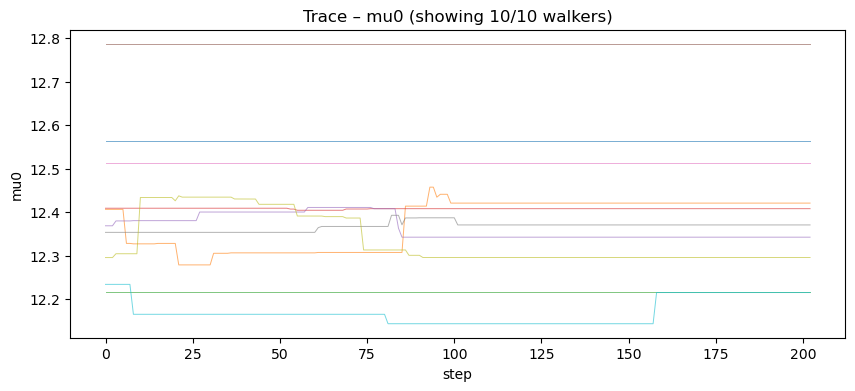

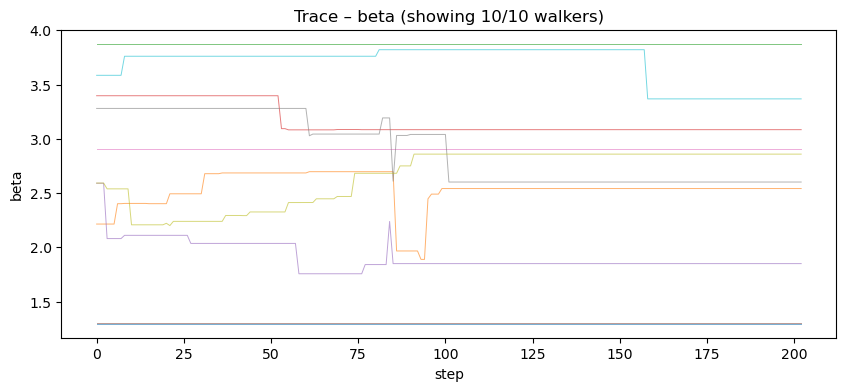

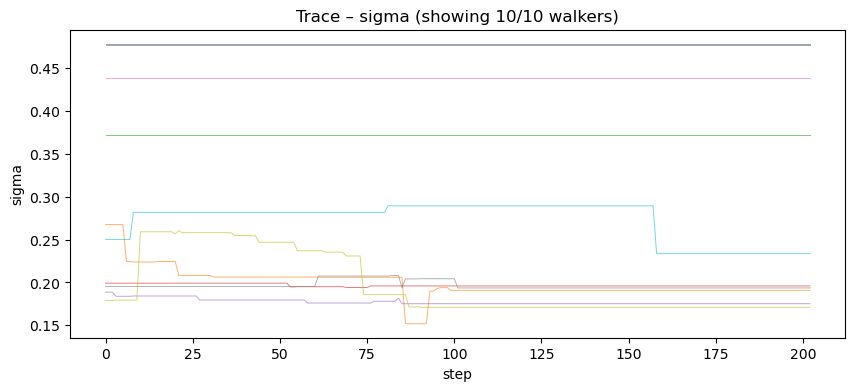

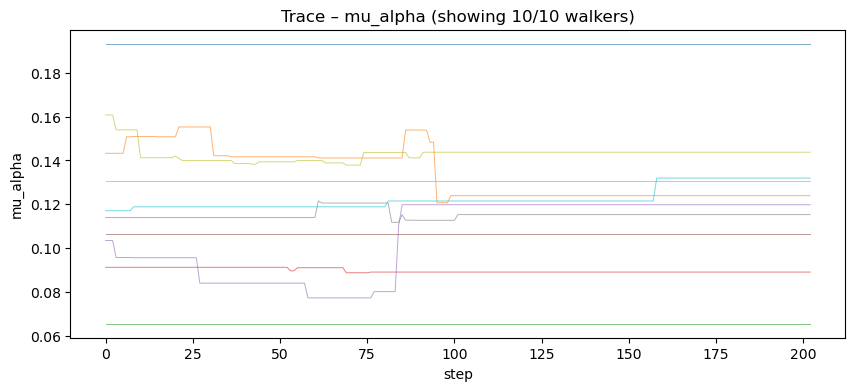

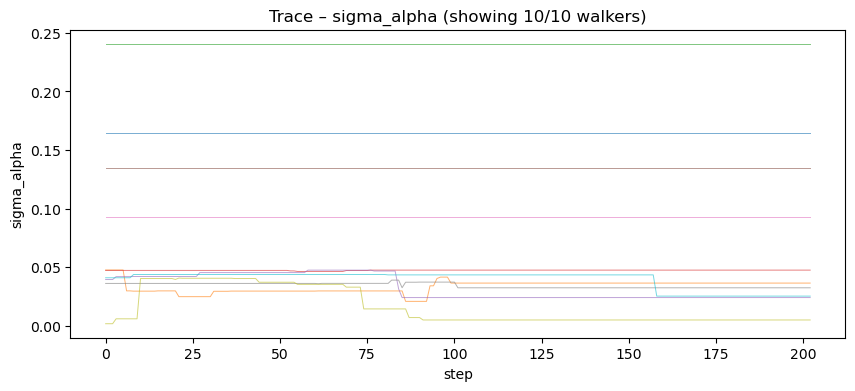

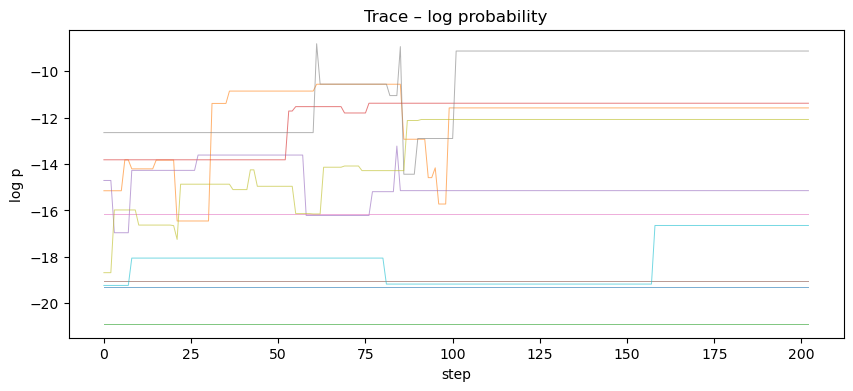

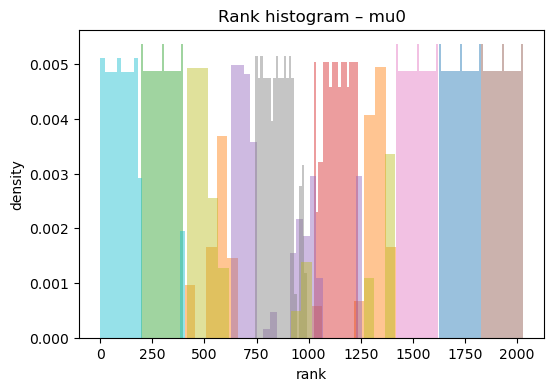

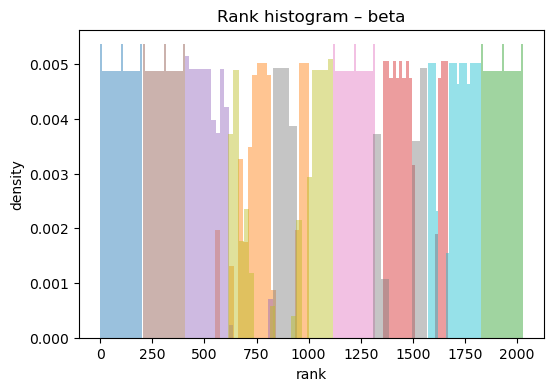

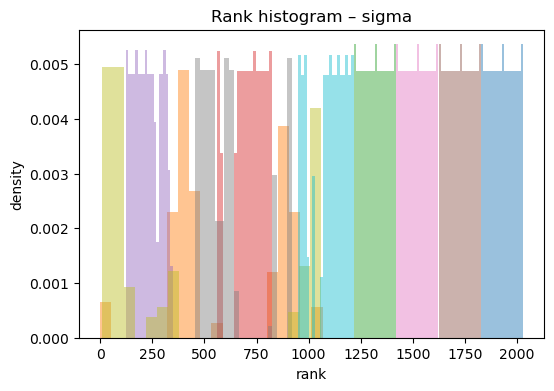

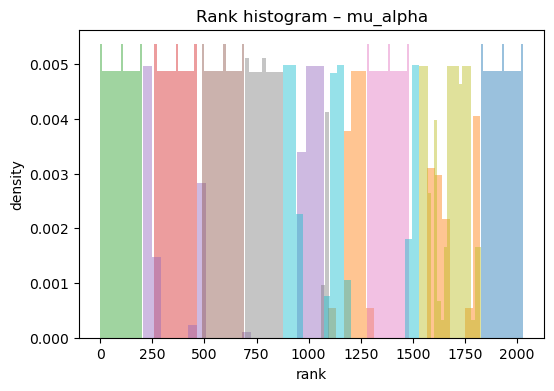

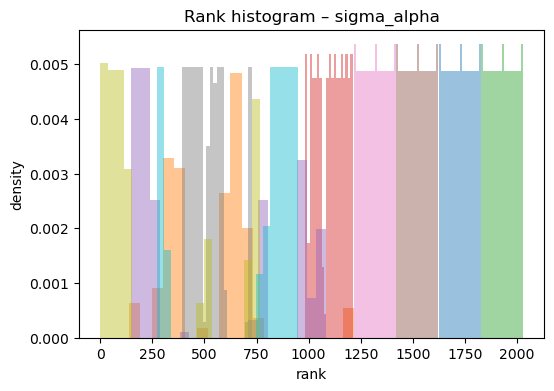

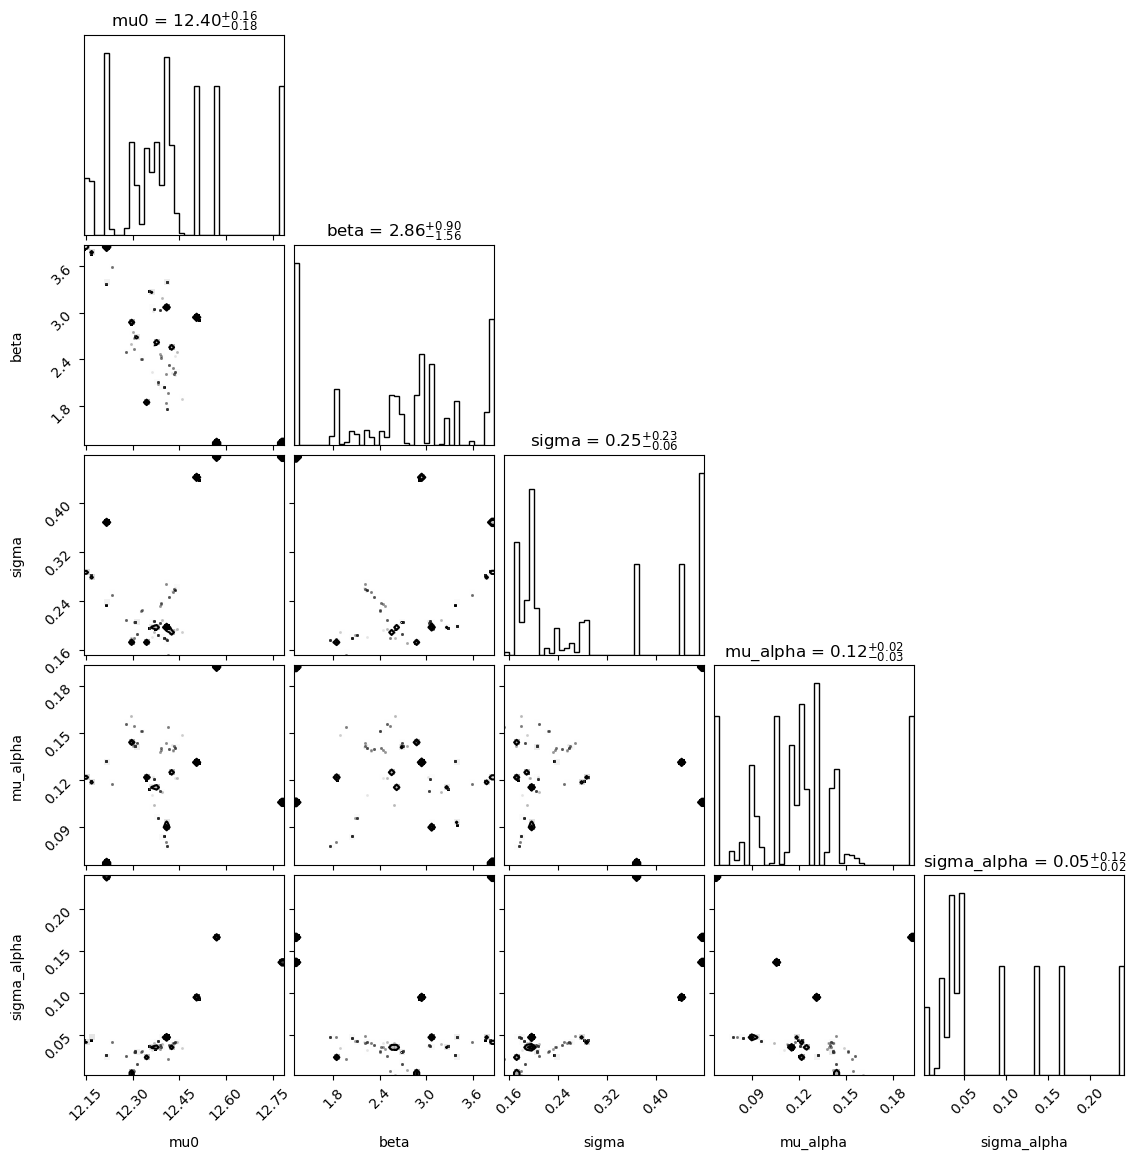

图像已保存到 ./diagnostics/


In [5]:
outdir = "diagnostics"
os.makedirs(outdir, exist_ok=True)

# Trace（参数）
_ = trace_plots(chain, param_names=param_names, max_walkers=24, outdir=outdir)

# Trace（log-prob）
plt.figure(figsize=(10,4))
for w in range(min(W, 24)):
    plt.plot(logp[:, w], alpha=0.6, lw=0.7)
plt.title("Trace – log probability")
plt.xlabel("step"); plt.ylabel("log p")
plt.savefig(os.path.join(outdir, "trace_logp.png"), dpi=150, bbox_inches="tight")
plt.show()

# Rank 直方图
_ = rank_plot(chain, param_names=param_names, bins=20, outdir=outdir)

# Corner 图（可选）
_ = corner_plot(chain, param_names=param_names, outpath=os.path.join(outdir, "corner.png"))
print(f"图像已保存到 ./{outdir}/")


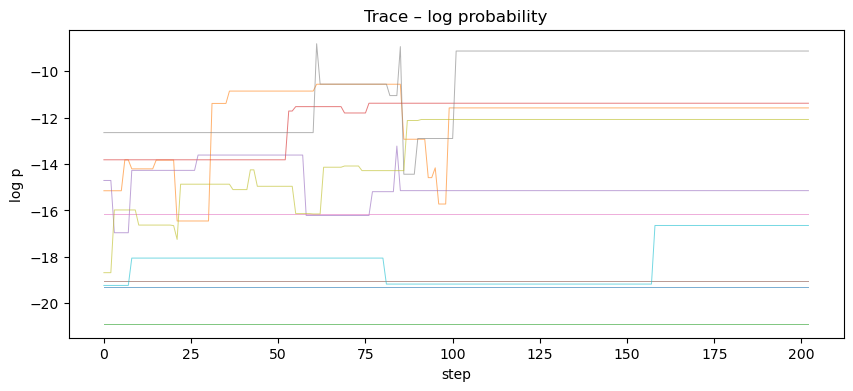

NameError: name 'worst' is not defined

In [7]:
outdir="diagnostics"; os.makedirs(outdir, exist_ok=True)

# log p trace
plt.figure(figsize=(10,4))
for w in range(min(W,24)): plt.plot(logp[:,w], alpha=0.6, lw=0.7)
plt.title("Trace – log probability"); plt.xlabel("step"); plt.ylabel("log p")
plt.savefig(f"{outdir}/trace_logp.png", dpi=150, bbox_inches="tight"); plt.show()

# 可疑参数 trace
for d in worst:
    plt.figure(figsize=(10,4))
    for w in range(min(W,24)): plt.plot(chain[:,w,d], alpha=0.6, lw=0.7)
    plt.title(f"Trace – {names[d]}"); plt.xlabel("step"); plt.ylabel(names[d])
    plt.savefig(f"{outdir}/trace_{names[d]}.png", dpi=150, bbox_inches="tight"); plt.show()

# 可疑参数 rank 直方图
S_,W_,D_=chain.shape; flat=chain.reshape(S_*W_,D_)
ranks=np.zeros_like(chain,int)
for d in range(D):
    order=np.argsort(flat[:,d], kind="mergesort"); inv=np.empty_like(order); inv[order]=np.arange(order.size)
    ranks[:,:,d]=inv.reshape(S_,W_)

for d in worst:
    plt.figure(figsize=(6,4))
    for w in range(W_): plt.hist(ranks[:,w,d], bins=20, density=True, alpha=0.45, histtype="stepfilled")
    plt.title(f"Rank histogram – {names[d]}"); plt.xlabel("rank"); plt.ylabel("density")
    plt.savefig(f"{outdir}/rank_{names[d]}.png", dpi=150, bbox_inches="tight"); plt.show()

print("Saved to ./diagnostics/")
